In [16]:
%matplotlib inline
from skimage import filters
from skimage import morphology
from skimage import img_as_float
from skimage import util
from scipy.ndimage.filters import gaussian_filter
from cytokit.function import data as ck_data
import numpy as np
import matplotlib.pyplot as plt

In [849]:
data_dir = '/lab/data/spheroid/20190215-mc38-dmso-control/gdoc_samp'
data_dir

'/lab/data/spheroid/20190215-mc38-dmso-control/gdoc_samp'

In [835]:
exp_dir = 'XY03'
df_z = ck_data.get_best_focus_data(osp.join(data_dir, exp_dir, 'output', 'v00'))
df_z

,region_index,tile_index,tile_x,tile_y,best_z
0,0,0,0,0,14
1,0,1,1,0,14
2,0,2,2,0,14
3,0,3,2,1,12
4,0,4,1,1,14
5,0,5,0,1,11
6,0,6,0,2,11
7,0,7,1,2,14
8,0,8,2,2,12


In [836]:
tile_index = 4
best_z = df_z['best_z'][df_z['tile_index']==tile_index].iloc[0]
img = io.imread(osp.join(data_dir, '{}/raw/1_{}_{:05d}_Z{:03d}_CH1.tif'.format(exp_dir, exp_dir, tile_index+1, best_z+1)))
# if img.ndim == 3:
#     img = img[..., 0]
img.shape, img.dtype, img.min(), img.max()

/usr/local/lib/python3.5/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


((1440, 1920), dtype('uint16'), 14232, 65535)

In [837]:
#io.imsave('/lab/data/tmp/img.tif', exposure.rescale_intensity(img, out_range='uint8').astype(np.uint8), imagej=True)

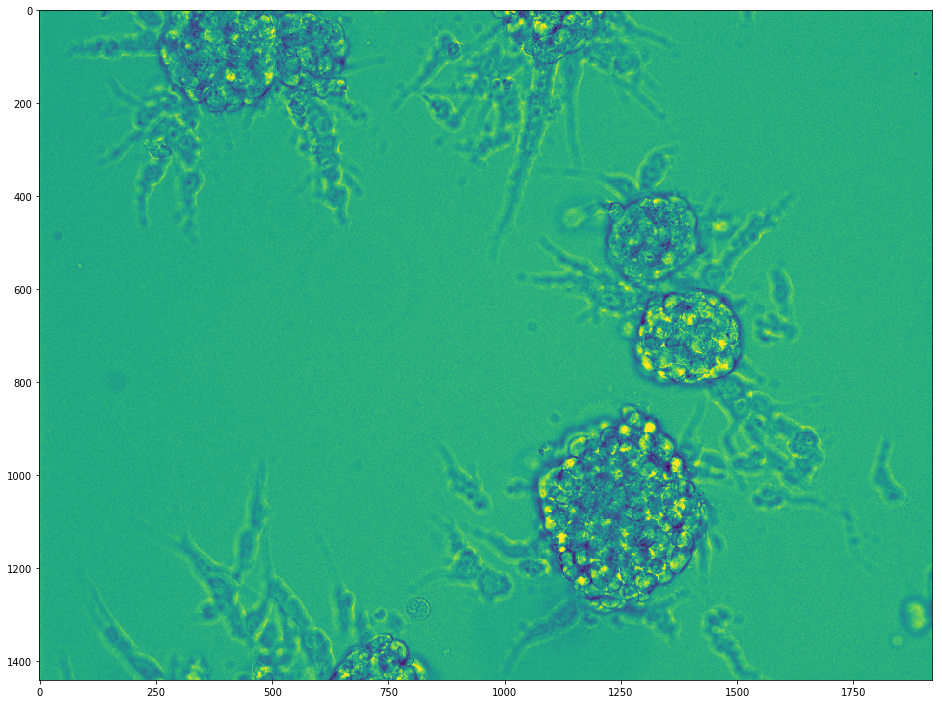

In [838]:
#plt.imshow(img.max(axis=0))
plt.imshow(img)
plt.gcf().set_size_inches(16, 16)

In [839]:
# #plt.imshow(img.max(axis=0))
# plt.imshow(filters.gaussian(filters.sobel(img), 64))
# #plt.imshow(filters.gaussian(img, 18))
# plt.colorbar()
# plt.gcf().set_size_inches(16, 16)

In [857]:
imgx = np.array([[0, 0, 1, 0], [0, 0, 1, 1], [0, 0, 0, 0]])
p = measure.regionprops(imgx)[0]
imgx

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 0, 0, 0]])

In [861]:
p.image

array([[ True, False],
       [ True,  True]])

In [844]:
from skimage import feature
from skimage import measure
from skimage import segmentation
from centrosome import propagate
from cytokit import math as ck_math
from scipy.ndimage.morphology import distance_transform_edt

#     # Invert gradient image and mask
#     img_sec_bin = ~img_grad_bin * img_mask
#     img_sec_bin = morphology.remove_small_objects(img_sec_bin, min_size=48)
#     img_sec_lbl = measure.label(img_sec_bin)
#     props = measure.regionprops(img_sec_lbl)
#     valid_ids = [
#         p.label for p in props 
#         if ck_math.circularity(p.area, p.perimeter) > .6
#     ]
#     img_sec_lbl[~np.isin(img_sec_lbl, valid_ids)] = 0
#     img_sec_seg = segmentation.watershed(np.ones_like(img), img_sec_lbl, mask=img_mask)

#     img_prim_seg[img_sec_lbl > 0] = 0
    
    
def segment(img):
    assert img.ndim == 3, 'Expecting 3D image, got shape %s' % (img.shape,)

    # Run max-z projection to create single 2D image (but record initial number of z planes)
    nz = img.shape[0]
    img = img.max(axis=0)

    # Verify 8 or 16 bit type before forcing to 8 bit (for median filtering)
    assert img.dtype in [np.uint8, np.uint16], 'Expecting 8 or 16 bit image but got type %s' % img.dtype
    if img.dtype == np.uint16:
        img = exposure.rescale_intensity(img, out_range='uint8').astype(np.uint8)
    assert img.dtype == np.uint8
    img_raw = img

    # Preprocess to remove outliers and blur
    img = filters.median(img, selem=morphology.square(3))
    img = filters.gaussian(img, sigma=3)

    # Median requires 8 or 16 bit images (or a warning is thrown) but gaussian filter
    # will convert result per img_as_float conventions leaving 0-1 image (verify that
    # and stretch to 0-1)
    assert img.min() >= 0 and img.max() <= 1, \
        'Expecting 0-1 image but got range %s - %s' % (img.min(), img.max())
    img = exposure.rescale_intensity(img, out_range=(0, 1))
    assert img.min() == 0 and img.max() == 1

    # Run open-close morphological reconstruction
    img_seed = morphology.erosion(img, selem=morphology.disk(8))
    img = morphology.reconstruction(img_seed, img, method='dilation')
    img_seed = morphology.dilation(img, selem=morphology.disk(8))
    img = morphology.reconstruction(img_seed, img, method='erosion')

    # Compute gradient, blur, and threshold to give reasonable outlines of objects
    img_grad = filters.sobel(img)
    img_grad = filters.gaussian(img_grad, sigma=1)
    img_grad_bin = img_grad > filters.threshold_li(img_grad)

    # Fill in outlines by performing large radius closing
    img_mask = morphology.remove_small_objects(img_grad_bin, min_size=64)
    img_mask = morphology.binary_closing(img_mask, selem=morphology.disk(8))
    img_mask = morphology.remove_small_holes(img_mask, area_threshold=2048)

    # Determine seed for primary object segmentation as peak local max in mask dist
    img_mask_dist = distance_transform_edt(img_mask)
    img_mask_dist = filters.gaussian(img_mask_dist, sigma=5) # Large sigma helps join nearby peaks
    img_markers = feature.peak_local_max(img_mask_dist, indices=False, exclude_border=False, min_distance=64)
    img_markers = measure.label(img_markers)
    img_basin = -img_mask_dist

    # Segment larger objects (i.e. spheroids)
    img_seg = segmentation.watershed(img_basin, img_markers, mask=img_mask).astype(np.uint16)

    return img_seg

res = segment(img[np.newaxis])

In [845]:
res.shape

(1440, 1920)

In [846]:
#res = morphology.dilation(res, morphology.disk(10))

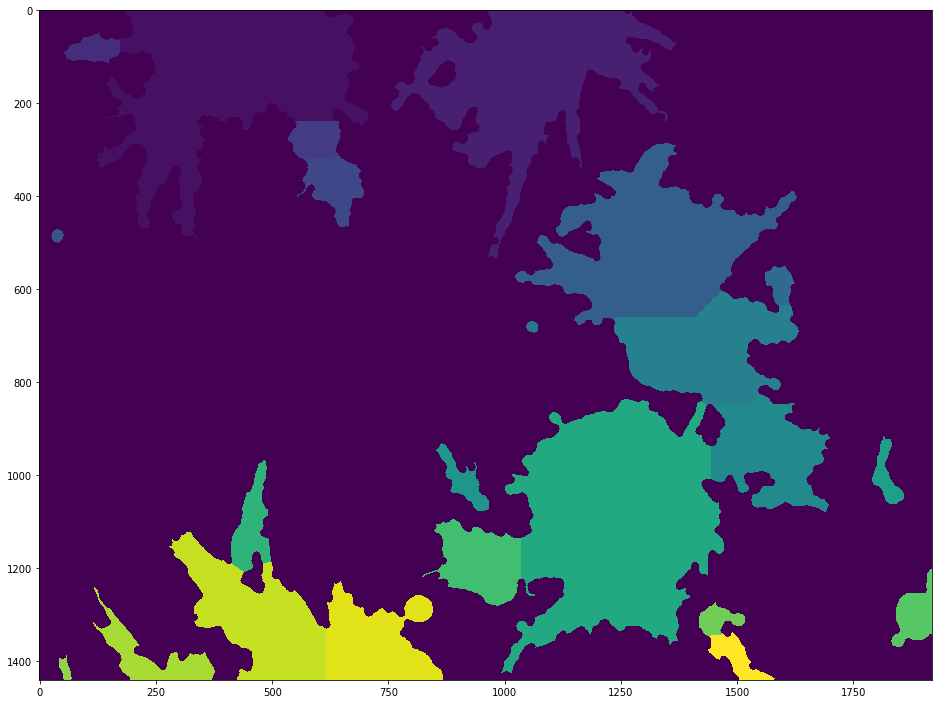

In [847]:
plt.imshow(res)
#plt.colorbar()
plt.gcf().set_size_inches(16, 16)

## OrganoSeg

In [ ]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None, size=14):
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(size, size * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image, cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()
    
def unsharp_mask(image, radius=1.0, amount=1.0, preserve_range=False):
    
    vrange = None  # Range for valid values; used for clipping.
    if preserve_range:
        fimg = image.astype(np.float)
    else:
        fimg = img_as_float(image)
        negative = np.any(fimg < 0)
        if negative:
            vrange = [-1., 1.]
        else:
            vrange = [0., 1.]
            
    blurred = gaussian_filter(image,
                              sigma=radius,
                              mode='reflect')

    result = image + (image - blurred) * amount
    if vrange is not None:
        return np.clip(result, vrange[0], vrange[1], out=result)
    return result

def clear_border(img):
    img[:,0] = img[:,1]
    img[:,-1] = img[:,-2]
    img[0,:] = img[1,:]
    img[-1,:] = img[-2,:]
    return img


def segment(img):
    # Assume img in [-1, 1]
    
    # Use Matlab defaults for imsharpen
    imgK = unsharp_mask(img, radius=1.0, amount=0.8, preserve_range=False)
    imgK = filters.median(imgK)
    
    # Erode and open
    imgIe = morphology.erosion(imgK, selem=morphology.disk(5))
    imgIobr = morphology.reconstruction(imgIe, imgK, method='dilation')
    
    # Opening-closing by reconstruction(Iobrcbr)
    # *This was verified as equivalent to dilation recon on inverted images
    imgIobrd = morphology.dilation(imgIobr, selem=morphology.disk(5))
    imgIobrcbr = morphology.reconstruction(imgIobrd, imgIobr, method='erosion')

    # Remove border
    imgIobrcbrClr = clear_border(imgIobrcbr.copy())

    # Threshold
    bwEdge = np.zeros_like(img, dtype=np.uint8)
    fudgeFactor = 1
    
    # Multi-scale checkbox
    # 20:10:ws{i}(1) => 20:10:100 => first:increment:second
    for j in np.arange(20, 110, 10):
    #for j in np.arange(100, 210, 10):
        thresh = filters.threshold_local(imgIobrcbrClr, j+1, method='mean', mode='nearest')
        bwEdgeIter = (imgIobrcbrClr > fudgeFactor*thresh).astype(np.uint8)
        bwEdge = bwEdge + bwEdgeIter
        
    return dict(
        K=imgK,
        Ie=imgIe,
        Iobr=imgIobr,
        Iobrd=imgIobrd,
        Iobrcbr=imgIobrcbr,
        IobrcbrClr=imgIobrcbrClr,
        bwEdge=bwEdge
    )


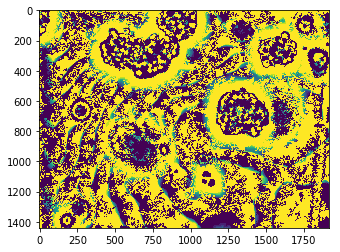

In [60]:
plt.imshow(res['bwEdge'])

In [13]:
# %Load images
#         I = bulkI{i};
#         %Sharpen
#         K = imsharpen(I);
#         %Smooth background
#         K = medfilt2(K);
        
#         %Opening and closing by reconstruction
#         %Create structure element
#         se = strel('disk', 5);
        
#         %Erode and open
#         Ie = imerode(K, se);
#         Iobr = imreconstruct(Ie, K);
        
#         %Opening-closing by reconstruction(Iobrcbr)
#         Iobrd = imdilate(Iobr, se);
#         Iobrcbr = imreconstruct(imcomplement(Iobrd), imcomplement(Iobr));
#         Iobrcbr = imcomplement(Iobrcbr);
        
#         %Remove border
#         Iobrcbr(1:end,1) = Iobrcbr([2 2:end],2);
#         Iobrcbr(1:end,end) = Iobrcbr([2 2:end],end-1);
#         Iobrcbr(1,1:end) = Iobrcbr(2,[2 2:end]);
#         Iobrcbr(end,1:end) = Iobrcbr(end-1,[2 2:end]);
        
#         %Threshold
#         bwEdge = zeros(size(I,1),size(I,2));
#         fudgeFactor = handles.thresh{i};
        
#         %Multi-scale checkbox?
#         if get(handles.checkbox2,'Value') == 1
#             for j = 20:10:ws{i}(1)
#                 bwEdgeIter = adaptivethreshold(Iobrcbr,[j j],fudgeFactor);
#                 bwEdge = bwEdge+bwEdgeIter;
#             end
#         guidata(hObject,handles);
        
#         %Remove small noise
#         bwsmall = bwareaopen(bwEdge, small{i});
        
#         %Smooth
#         bwsmooth = imclose(bwsmall,ones(3,3));
        
#         %fill holes
#         bw_holes = bwfill(bwsmooth,'holes');
        
#         %Store pre-watershed image
#         handles.bw_nowater{i} = bw_holes;
        
#         %Watershed checkbox?
#         if get(handles.togglebutton4,'Value') == 1
#             %Find distance transform and smooth
#             dist = bwdist(imcomplement(double(bw_holes)));
#             smooth = imgaussfilt(dist,5);
#             dist2 = -smooth;
#             dist2(~bw_holes) = -Inf;
            
#             %Watershed based on distance transform, splitting organoids
#             L = watershed(dist2);
            
#             %Remove noise based on size threshold
#             bwlil = bwareaopen(L,small{i});
#             %Clear border
#             bwfinal = imclearborder(bwlil);
#             bwfinal = logical(bwfinal);
#             handles.bwfinal{i} = bwfinal;
#         else
#             %Clear border
#             bw_nobord = imclearborder(bw_holes);
#             %make logical
#             bwfinal = logical(bw_nobord);
#             handles.bwfinal{i} = bwfinal;
#         end
        
    
    
# function bw = adaptivethreshold(IM,ws,fudgeFactor)
# %ADAPTIVETHRESHOLD An adaptive thresholding algorithm that seperates the
# %foreground from the background with nonuniform illumination.
# %  bw=adaptivethreshold(IM,ws,C) outputs a binary image bw with the local 
# %   threshold mean-C or median-C to the image IM.
# %  ws is the local window size.
# %  tm is 0 or 1, a switch between mean and median. tm=0 mean(default); tm=1 median.
# %
# %  Contributed by Guanglei Xiong (xgl99@mails.tsinghua.edu.cn)
# %  at Tsinghua University, Beijing, China.
# %
# %  For more information, please see
# %  http://homepages.inf.ed.ac.uk/rbf/HIPR2/adpthrsh.htm

# if (nargin<3)
#     error('You must provide the image IM, the window size ws, and C.');
# elseif (nargin==3)
#     tm=0;
# end

# IM=mat2gray(IM);

# if tm==0
#     mIM=imfilter(IM,fspecial('average',ws),'replicate');
# else
# end

# sIM=mIM-IM;
# % sIM = imcomplement(sIM);

# thresh=graythresh(sIM);

# % thresh = 1;
# % [idx,c] = kmeans(sIM(:),2);

# bw = imbinarize(sIM,thresh*fudgeFactor);
